In [54]:
import lusid
import lusid.models as models
import os
from msrest.authentication import BasicTokenAuthentication

api_url = os.getenv("FBN_LUSID_API_URL")
api_token = {"access_token": os.environ["ACCESS_TOKEN"]}
credentials = BasicTokenAuthentication(api_token)
client = lusid.LUSIDAPI(credentials, api_url)

In [55]:
import uuid
from datetime import datetime
import pytz
from collections import namedtuple

def assert_response_is_not_error(expected_type, response):

    if isinstance(response, models.ErrorResponse):
        self.fail(response.detailed_message)
    elif isinstance(response, expected_type):
        return response
    else:
        self.fail("unknown response: {0}".format(type(response)))
            
def build_trade(trade_spec):
    return models.TradeDto(
        trade_id=str(uuid.uuid4()),
        type="StockIn",
        security_uid=trade_spec.id,
        settlement_currency="GBP",
        trade_date=trade_spec.trade_date,
        settlement_date=trade_spec.trade_date,
        units=100,
        trade_price=trade_spec.price,
        total_consideration=100 * trade_spec.price,
        source="Client")

scope = "finbourne"
guid = str(uuid.uuid4())
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)

request = models.CreatePortfolioRequest("portfolio-{0}".format(guid), "id-{0}".format(guid), "GBP", effective_date)

#   create the portfolio
result = client.create_portfolio(scope, request)

assert_response_is_not_error(models.PortfolioDto, result)

assert(result.id.code == request.code)

portfolio_id = result.id.code

TradeSpec = namedtuple('TradeSpec', 'id price trade_date')
trade_specs = [
    TradeSpec("FIGI_BBG001S7Z574", 101, effective_date),
    TradeSpec("FIGI_BBG001SRKHW2", 102, effective_date),
    TradeSpec("FIGI_BBG000005547", 103, effective_date)
]
trade_specs.sort(key=lambda ts: ts.id)

new_trades = list(map(build_trade, trade_specs))

#   add initial batch of trades
add_trades_result = client.upsert_trades(scope, portfolio_id, new_trades)
assert_response_is_not_error(models.UpsertPortfolioTradesDto, add_trades_result)

In [56]:
check_exists_result = client.get_analytic_store(scope,
                                                effective_date.year,
                                                effective_date.month,
                                                effective_date.day)

#   create an analytic store
if isinstance(check_exists_result, models.ErrorResponse) and check_exists_result.code == "AnalyticStoreNotFound":
    analytic_store_request = models.CreateAnalyticStoreRequest(scope, effective_date)
    analytic_store_result = client.create_analytic_store(analytic_store_request)
    assert_response_is_not_error(models.AnalyticStoreDto, analytic_store_result)

prices = [
    models.SecurityAnalyticDataDto("FIGI_BBG001S7Z574", 100),
    models.SecurityAnalyticDataDto("FIGI_BBG001SRKHW2", 200),
    models.SecurityAnalyticDataDto("FIGI_BBG000005547", 300)
]

#   add prices
prices_result = client.insert_analytics(scope, effective_date.year, effective_date.month, effective_date.day, prices)
assert_response_is_not_error(models.AnalyticStoreDto, prices_result)

In [57]:
aggregation_request = models.AggregationRequest(
    recipe_scope=scope,
    recipe_key=scope,
    metrics=[
        models.AggregateSpec("Holding/default/PV", "Proportion"),
        models.AggregateSpec("Holding/default/PV", "Sum")
    ],
    group_by=["Security/default/CommonName"],
    effective_at=effective_date
)

#   do the aggregation
aggregation_result = client.get_nested_aggregation_by_portfolio(scope, portfolio_id, aggregation_request)
aggregation = assert_response_is_not_error(models.NestedAggregationResponse, aggregation_result)

In [58]:
for item in aggregation.data.children:
    print("{0}".format(item.group_property_value))
    for key, value in item.properties.items():
        print("\t{0}\t{1}".format(key, value))

GENERAL ACCIDENT PLC
	Holding/default/PV%	0.5
	Holding/default/PV	30000.0
MCBRIDE PLC
	Holding/default/PV%	0.16666666666666666
	Holding/default/PV	10000.0
CRANEWARE PLC
	Holding/default/PV%	0.3333333333333333
	Holding/default/PV	20000.0


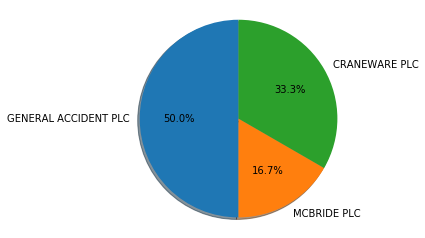

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = []
values = []
for item in aggregation.data.children:
    labels.append(item.group_property_value)
    values.append(item.properties["Holding/default/PV%"] * 100)
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()